In [1]:
import torch
import numpy as np
import gc
from face_lib.dataset_classes.lightning_datasets import MXFaceDataset
from face_lib.models.lightning_wrappers import ResNet
import albumentations as A
from face_lib.models.scf import SoftmaxWeights
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
# self.alb_transform = A.Compose(
#                 [A.GridDistortion(num_steps = 5, distort_limit = 0.3, p = 0.5),
#                  A.GridDistortion(num_steps = 10, distort_limit = 0.5, p = 0.5),
#                  A.GridDistortion(num_steps = 50, distort_limit = 1.0, p = 0.5)
#                   ],
#                 p = 0.25
#             )

In [3]:
augments = [
    {
        "class_path": "albumentations",
        "aug_name": "GridDistortion",
        "init_args": {"num_steps": 5, "distort_limit": 0.3, "p": 0.5},
    },
    {
        "class_path": "albumentations",
        "aug_name": "GridDistortion",
        "init_args": {"num_steps": 10, "distort_limit": 0.5, "p": 0.5},
    },
    {
        "class_path": "albumentations",
        "aug_name": "GridDistortion",
        "init_args": {"num_steps": 50, "distort_limit": 1.0, "p": 0.5},
    },
]

aug_prob = 1.0

In [4]:
ms_ds = MXFaceDataset(
    "/app/datasets/ms1m",
    test=False,
    album_augments=augments,
    album_probability=aug_prob,
)
labels = np.load("/app/datasets/ms1m/labels.npy")

/home/kolesnikov/miniconda/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [5]:
backbone = ResNet(
    "iresnet50_normalized",
    "/app/model_weights/backbone/ms1mv3_arcface_r50/backbone.pth",
    learnable=False,
)

/app/face_lib/models/lightning_wrappers.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  backbone_dict = torch.load(weights)


In [6]:
radius = 64

softmax_weights = SoftmaxWeights(
    softmax_weights_path="/app/model_weights/backbone/ms1mv3_arcface_r50/softmax_weight.pt",
    radius=radius,
).softmax_weights

/app/face_lib/models/scf.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.softmax_weights = torch.load(softmax_weights_path)


In [7]:
# Dataloader
dl = DataLoader(
    ms_ds,
    batch_size=75,
    drop_last=False,
    shuffle=False,
    num_workers=40,
)

In [8]:
backbone.to("cuda:1")
backbone.eval()

ResNet(
  (backbone): IResNetNorm(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=64)
    (layer1): Sequential(
      (0): IBasicBlock(
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (prelu): PReLU(num_parameters=64)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (downsample): Sequential(
          (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [9]:
softmax_weights = softmax_weights.to("cuda:1")

In [10]:
res = []
for batch in tqdm(dl):
    batch_labels = batch[1].to("cuda:1")
    batch_cuda = batch[0].to("cuda:1")
    output = backbone(batch_cuda)["feature"]
    wc = softmax_weights[batch_labels, :]
    cosine_sim = torch.sum(output * wc, dim=1, keepdim=True) / radius
    cos_for_save = cosine_sim.detach().cpu().numpy()
    res.append(cos_for_save)

  0%|          | 0/77636 [00:00<?, ?it/s]/app/face_lib/models/iresnet.py:198: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.fp16):
100%|██████████| 77636/77636 [44:51<00:00, 28.85it/s]  


In [11]:
len(res)

77636

In [12]:
new_res = np.concatenate(res, axis=0)

In [13]:
new_res.shape

(5822653, 1)

In [14]:
np.save("/app/cache/cosine_cache/ms1m_grid_distort_100%.npy", new_res)

In [15]:
np.mean(new_res)

0.34807858

In [16]:
import numpy as np

In [17]:
grid_75 = np.load("/app/cache/cosine_cache/ms1m_grid_distort_75%.npy")
grid_25 = np.load("/app/cache/cosine_cache/ms1m_grid_distort_25%.npy")
grid_100 = np.load("/app/cache/cosine_cache/ms1m_grid_distort_100%.npy")

In [18]:
grid_25_zip = np.array(
    list(zip(["25%" for i in range(grid_25.shape[0])], list(grid_25[:, 0])))
)
grid_75_zip = np.array(
    list(zip(["75%" for i in range(grid_75.shape[0])], list(grid_75[:, 0])))
)
grid_100_zip = np.array(
    list(zip(["100%" for i in range(grid_100.shape[0])], list(grid_100[:, 0])))
)

In [28]:
grid_25_zip.shape

(5822653, 2)

In [29]:
data_full = np.concatenate([grid_25_zip, grid_75_zip, grid_100_zip])

In [30]:
data_full = list(data_full)

In [31]:
df = pd.DataFrame(data_full, columns=["percent", "cosinus"])

In [35]:
df.head()

,percent,cosinus
0,25%,0.7834577
1,25%,-0.01819027
2,25%,0.2703865
3,25%,0.75598466
4,25%,0.8526081


In [39]:
data = {"25%": grid_25[:, 0], "75%": grid_75[:, 0], "100%": grid_100[:, 0]}

Text(0.5, 9.444444444444438, 'Cosine Sim')

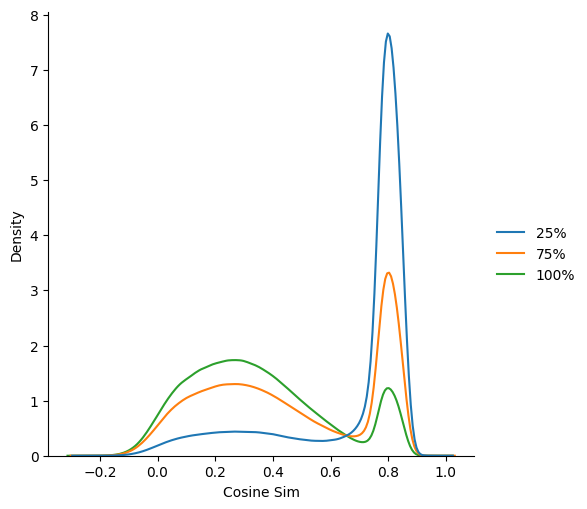

In [40]:
sns.displot(
    data,
    kind="kde",
    # x="Cosine Sim",
    log_scale=False,
    common_norm=False,
)
plt.xlabel(f"Cosine Sim")
# plt.savefig(out_name, dpi=300)